In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# filter only test playersex
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

1187

In [25]:
df.head()

,playerId,target1,target2,target3,target4,date,home,pstatsDate,battingOrder__ptvf,groundOuts__ptvf,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaT,NaN,NaN,...,0,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaT,NaN,NaN,...,1,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaT,NaN,NaN,...,2,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaT,NaN,NaN,...,3,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaT,NaN,NaN,...,4,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661


### preprocessing with pipelines

In [26]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info
from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [27]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [28]:
# for the statistics, we will compute them and then resuse them
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[30], drop_index=False)
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])
target_stats_table = target_stats_tmf.fit_transform(df)


target_stats_table.head()

,playerId,date,target1__mean__30d,target1__median__30d,target1__std__30d,target2__mean__30d,target2__median__30d,target2__std__30d,target3__mean__30d,target3__median__30d,target3__std__30d,target4__mean__30d,target4__median__30d,target4__std__30d
0,405395,2018-01-01,0.151872,0.151872,NaN,21.449417,21.449417,NaN,0.112952,0.112952,NaN,22.990196,22.990196,NaN
1,405395,2018-01-02,0.144139,0.144139,0.010936,16.214001,16.214001,7.403996,0.104677,0.104677,0.011702,19.329685,19.329685,5.176745
2,405395,2018-01-03,0.117580,0.136406,0.046648,13.884730,10.978585,6.609544,0.103606,0.101464,0.008480,20.610733,22.990196,4.280490
3,405395,2018-01-04,0.094239,0.100433,0.060248,12.956289,10.574775,5.707194,0.103317,0.101956,0.006948,24.297829,23.081512,8.160501
4,405395,2018-01-05,0.106902,0.136406,0.059365,11.223893,10.170965,6.279732,0.091957,0.101464,0.026104,21.907820,22.990196,8.860362


In [29]:
## merge computed statistics
reuse_computed_stats = Pipeline([('merge_stats', FeaturesTable(target_stats_table, lags=[45], clip_max=True)),
                                 ('fillnan', FunctionTransformer(fillna)),
                                 ('normalize', PdScaleNorm())
                                ])

In [30]:
# for continuous features, we will filter them and then fill nan values and normalize them

continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=pp_cols)),
                                ('fillnan', FunctionTransformer(fillna, kw_args={'fill_value': -1}))
                               ])

In [31]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([('stats', reuse_computed_stats), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ])

In [32]:
# main pipeline with all steps 
pipeline = Pipeline([#('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [33]:
pipeline

Pipeline(steps=[('features_generation',
                 PdFeatureUnion(transformer_list=[('stats',
                                                   Pipeline(steps=[('merge_stats',
                                                                    FeaturesTable(lags=[45],
                                                                                  table=         playerId       date  target1__mean__30d  target1__median__30d  \
0          405395 2018-01-01            0.151872              0.151872   
1          405395 2018-01-02            0.144139              0.144139   
2          405395 2018-01-03            0.117580              0.136406   
3          405395 2018-01-04            0.094239              0.100433   
4          405395 2018-01-05            0.106902...
                                                                   ('fillnan',
                                                                    FunctionTransformer(func=<function fillna at 0x7fddcc0f69d0>)),
   

In [34]:
from data.split import SplitData

In [35]:
df = filter_by_id(df, [660271])

# df = df[pp_cols + ['rbi__ptvf']]

In [36]:
df.head()

,playerId,target1,target2,target3,target4,date,home,pstatsDate,battingOrder__ptvf,groundOuts__ptvf,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,660271,0.0,6.225681,0.000000,31.470588,2018-01-01,NaN,NaT,NaN,NaN,...,0,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
1,660271,0.0,3.578205,3.468022,16.180451,2018-01-02,NaN,NaT,NaN,NaN,...,1,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
2,660271,0.0,3.617216,20.326315,22.012038,2018-01-03,NaN,NaT,NaN,NaN,...,2,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
3,660271,0.0,4.491452,0.737624,34.008594,2018-01-04,NaN,NaT,NaN,NaN,...,3,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719
4,660271,0.0,1.650581,0.096786,12.240974,2018-01-05,NaN,NaT,NaN,NaN,...,4,False,Offseason,1994-07-05,2018-03-29,Japan,95.25432,Pitcher,1.9304,25.561719


In [37]:
# split the data on 2021-03-01 with a valid ds of 61 days
sp = SplitData("2021-04-01", test_days=500)

In [38]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [39]:
%%time
# train the pipeline only with the train dataset
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 136 ms, sys: 506 µs, total: 137 ms
Wall time: 136 ms


Pipeline(steps=[('features_generation',
                 PdFeatureUnion(transformer_list=[('stats',
                                                   Pipeline(steps=[('merge_stats',
                                                                    FeaturesTable(lags=[45],
                                                                                  table=         playerId       date  target1__mean__30d  target1__median__30d  \
0          405395 2018-01-01            0.151872              0.151872   
1          405395 2018-01-02            0.144139              0.144139   
2          405395 2018-01-03            0.117580              0.136406   
3          405395 2018-01-04            0.094239              0.100433   
4          405395 2018-01-05            0.106902...
                                                                   ('fillnan',
                                                                    FunctionTransformer(func=<function fillna at 0x7fddcc0f69d0>)),
   

In [40]:
%%time
# transform all dataset
features = pipeline.transform(df)

CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 150 ms


In [41]:
pd.options.display.max_rows = len(features.columns)
features.T.head(len(features.columns))

,0,1,2,3,4,5,6,7,8,9,...,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293
target1__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.820801,0.848633,0.796875,0.798340,0.820312,0.826172,0.815918,0.809570,0.754883,0.713867
target1__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.667480,0.667480,0.612305,0.612305,0.667480,0.667480,0.667480,0.667480,0.584473,0.516602
target1__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797852,0.843262,0.839844,0.838379,0.836426,0.831543,0.839844,0.846191,0.842773,0.845215
target2__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.784180,0.784180,0.774414,0.789062,0.805664,0.811035,0.806152,0.798828,0.789062,0.770996
target2__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.773926,0.773926,0.738770,0.753906,0.789551,0.789551,0.789551,0.789551,0.789551,0.753906
target2__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.810059,0.810059,0.793457,0.776855,0.764160,0.749023,0.763184,0.788086,0.806152,0.805664
target3__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.756348,0.724609,0.686035,0.713379,0.734863,0.726074,0.722656,0.717773,0.659180,0.613281
target3__median__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.586426,0.586426,0.586426,0.651855,0.651855,0.651855,0.651855,0.651855,0.586426,0.525879
target3__std__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.934570,0.889648,0.839355,0.832031,0.874023,0.886230,0.891113,0.898438,0.865234,0.847168
target4__mean__30d__45lag,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.725586,0.730469,0.688477,0.681641,0.689941,0.677246,0.688965,0.690430,0.682617,0.675781


In [42]:
# change the dtypes of the target (pytorch likes float32 and not float64)
df[target_cols] = df[target_cols].astype(np.float32)

In [43]:
train_idx.shape

(1294,)

In [44]:
train_idx.shape

(1294,)

In [45]:
train_data = sp.filter(features, train_idx)

raw_train_df = sp.filter(df, train_idx)

In [46]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [47]:
train_data.shape, raw_train_df.shape

((1186, 110), (1186, 117))

In [48]:
valid_data.shape, raw_valid_df.shape

((108, 110), (108, 117))

In [49]:
# add the target to features ds
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [100]:
cont_features = features.columns[features.std() > 0]

In [101]:
cont_features

Index(['target1__mean__30d__45lag', 'target1__median__30d__45lag',
       'target1__std__30d__45lag', 'target2__mean__30d__45lag',
       'target2__median__30d__45lag', 'target2__std__30d__45lag',
       'target3__mean__30d__45lag', 'target3__median__30d__45lag',
       'target3__std__30d__45lag', 'target4__mean__30d__45lag',
       ...
       'playerTeamDivisionleader', 'playerTeamLasttenwins',
       'playerTeamLasttenlosses', 'playerTeamXwinlosspct',
       'playerTeamHomewinpct', 'playerTeamAwaywinpct',
       'playerTeamHomewinpct__Date__Ranked',
       'playerTeamAwaywinpct__Date__Ranked', 'playerTeamWinpct__Date__Ranked',
       'playerBMI'],
      dtype='object', length=107)

In [102]:
from sklearn.linear_model import Lasso

In [103]:
models = []
for target_name in target_cols:
    _model = Lasso(alpha=0.5)
    _model.fit(train_data[cont_features], train_data[target_name])
    models.append(_model)
    
prediction = np.stack([_model.predict(valid_data[cont_features])
                       for _model in models], axis=1)

In [104]:
yhat_cols  = ['yhat1', 'yhat2', 'yhat3', 'yhat4']

In [105]:
valid_test_prediction = pd.DataFrame(prediction, columns=yhat_cols)

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]
recursive_prediction=valid_test_prediction

In [106]:
from evaluate.metrics import compute_metrics

In [107]:
# last_mean_prediction = (raw_valid_df.set_index('date').groupby(['playerId'])[target_cols]
#                         .rolling(window=7, min_periods=1).mean().reset_index())
# last_mean_prediction

# hardest_ids = [660271]
# hardest_idx = raw_valid_df['playerId'].isin(hardest_ids)

# yhat_cols = ['yhat1', 'yhat2', 'yhat3', 'yhat4']
# valid_test_prediction_with_last_mean = valid_test_prediction.copy(deep=True)
# valid_test_prediction_with_last_mean.loc[hardest_idx, yhat_cols] = last_mean_prediction.loc[hardest_idx, target_cols].to_numpy()

# valid_test_prediction_with_last_mean

In [108]:
# valid_test_prediction.loc[hardest_idx].head()

In [109]:
# valid_test_prediction_with_last_mean.loc[hardest_idx].head()

In [110]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 34.11427741923182,
 'mae_1': 22.657359745145968,
 'mae_2': 38.15404655180899,
 'mae_3': 33.64645572880578,
 'mae_4': 41.999247651166534}

In [111]:
(valid_test_prediction.groupby(valid_test_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,21.636733,14.569453,25.055413,24.014267,22.907801
5,32.884198,20.482252,43.680750,29.865341,37.508448
6,33.251273,17.622162,37.157803,32.153703,46.071426
7,59.899507,49.782154,52.949252,60.173680,76.692943


In [112]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 34.11427741923182,
 'mae_1': 22.657359745145968,
 'mae_2': 38.15404655180899,
 'mae_3': 33.64645572880578,
 'mae_4': 41.999247651166534}

In [113]:
april_set = valid_test_prediction[valid_test_prediction['date'].between('2021-04-01', '2021-04-30')]

In [114]:
(april_set.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,21.636733,14.569453,25.055413,24.014267,22.907801


In [115]:
(valid_test_prediction.groupby(['playerId', valid_test_prediction.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     59.899507  49.782154  52.949252  60.173680  76.692943
         6     33.251273  17.622162  37.157803  32.153703  46.071426
         5     32.884198  20.482252  43.680750  29.865341  37.508448
         4     21.636733  14.569453  25.055413  24.014267  22.907801

In [65]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [66]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [67]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [68]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

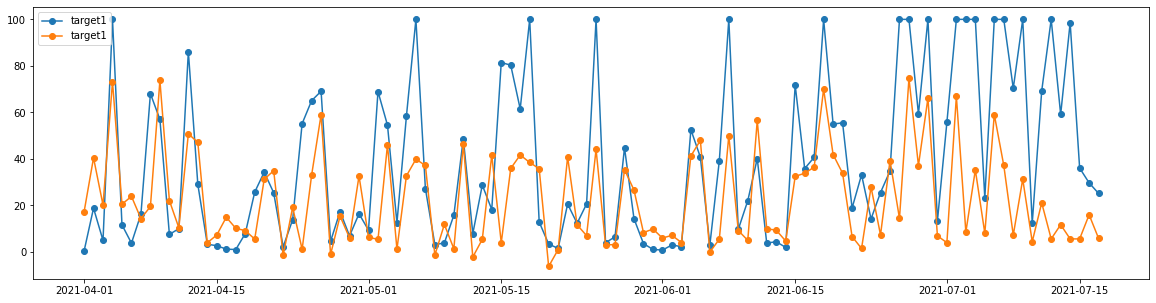

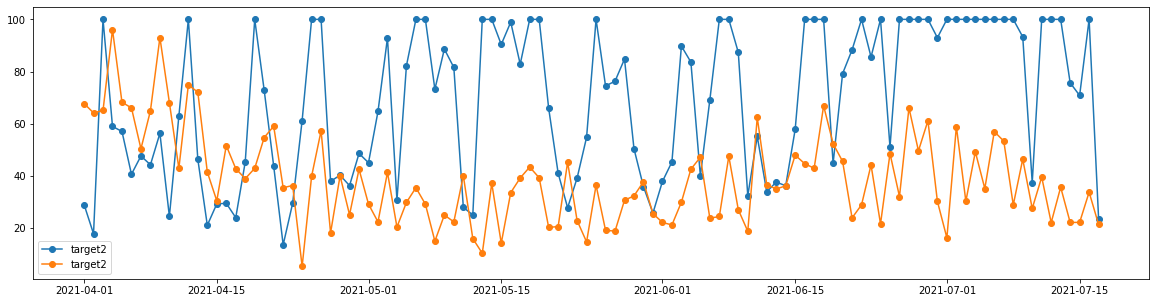

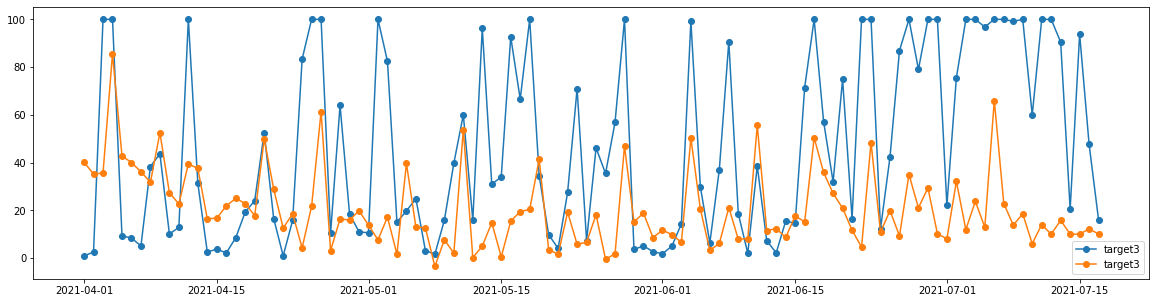

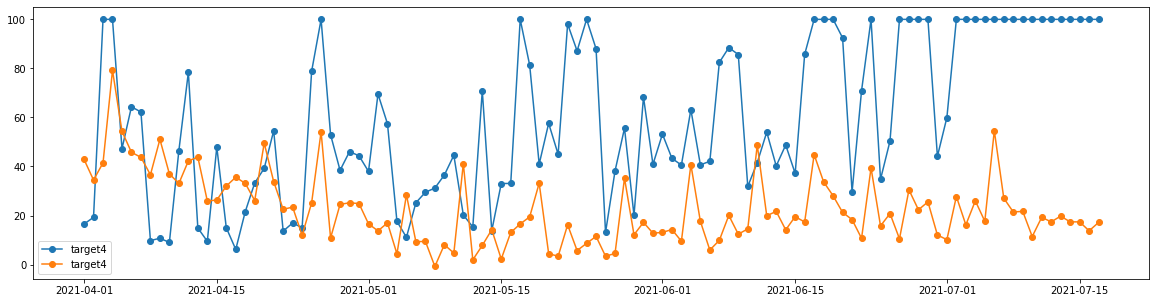

In [69]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

In [70]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [71]:
fi_data = valid_data

In [72]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [73]:
all_features_list = list(features.columns)

In [74]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

NameError: name 'output' is not defined

In [75]:
fi_reg

NameError: name 'fi_reg' is not defined

In [ ]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

In [ ]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)

In [90]:
drop_lstm_pred = pd.read_csv( 'prediction/drop_lstm/april_to_jul.csv', parse_dates=['date'])

In [91]:
drop_lstm_pred = pd.concat([drop_lstm_pred, valid_test_prediction], ignore_index=True)

In [93]:
drop_lstm_pred = drop_lstm_pred.groupby(['playerId', 'date']).mean().reset_index()

In [94]:
# drop_lstm_pred.loc[drop_lstm_pred['playerId'] == 660271, yhat_cols] = valid_test_prediction[yhat_cols].to_numpy()

In [95]:
drop_lstm_pred

,playerId,date,yhat1,yhat2,yhat3,yhat4,target1,target2,target3,target4
0,405395,2021-04-01,1.021850,11.515089,0.428298,15.365670,9.051319,37.249410,84.337685,61.795190
1,405395,2021-04-02,18.388480,21.680859,8.543251,25.408033,23.797577,16.486390,1.830379,43.453770
2,405395,2021-04-03,0.832838,11.832278,0.537509,15.734527,1.582325,11.661470,0.446259,16.009968
3,405395,2021-04-04,0.593775,11.363600,0.254093,14.432013,0.398015,17.862383,0.236858,11.990868
4,405395,2021-04-05,1.384460,14.508149,0.638930,17.683853,0.105217,29.070086,0.311580,18.445448
...,...,...,...,...,...,...,...,...,...,...
128191,685503,2021-07-13,0.000016,0.028266,0.000005,0.021659,0.001183,0.185048,0.001660,0.191695
128192,685503,2021-07-14,0.000018,0.024033,0.000004,0.020871,0.003569,0.263286,0.000000,0.235223
128193,685503,2021-07-15,0.000034,0.054639,0.000010,0.032916,0.002493,0.252499,0.002260,0.330065
128194,685503,2021-07-16,0.000043,0.059577,0.000012,0.036631,0.001662,0.203081,0.000722,0.258152


In [96]:
compute_metrics(drop_lstm_pred)

{'mae_mean': 1.3291228680766167,
 'mae_1': 1.0703064375091822,
 'mae_2': 2.048235909059259,
 'mae_3': 0.8405573285852264,
 'mae_4': 1.3573917971527991}

In [116]:
hardest_id = filter_by_id(drop_lstm_pred, [660271])

(hardest_id.groupby(['playerId', valid_test_prediction.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     50.228589  41.404775  41.660235  51.460147  66.389198
         5     28.448786  18.138913  38.015229  26.920901  30.720101
         6     28.401040  14.260445  33.178878  27.388404  38.776434
         4     20.310191  13.770265  21.002232  22.698548  23.769721